In [1]:
# Set environmental variables with google service credentials
import os
%env GOOGLE_APPLICATION_CREDENTIALS=/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json
print(os.getenv('GOOGLE_APPLICATION_CREDENTIALS'))

env: GOOGLE_APPLICATION_CREDENTIALS=/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json
/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json


In [2]:
# import necessary libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from google.cloud import bigquery

bqclient = bigquery.Client()

In [3]:
# Test BQ Connect
def implicit():
    from google.cloud import storage

    # If you don't specify credentials when constructing the client, the
    # client library will look for credentials in the environment.
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

implicit()

[]


In [4]:
# Download query results.
profit_loss_timeseries = """
SELECT 
    DATE_TRUNC(date, month) AS year_month,
    category_name,
    county,
    SUM(state_bottle_retail) AS retail, 
    SUM(state_bottle_cost) AS cost
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
WHERE date >= '2018-01-01'
    AND category_name IS NOT NULL
GROUP BY year_month, category_name, county
"""

profit_loss_timeseries = (
    bqclient.query(profit_loss_timeseries)
    .result()
    .to_dataframe(
        create_bqstorage_client=True,
    )
)

In [5]:
profit_loss_timeseries['year_month'] = pd.to_datetime(profit_loss_timeseries['year_month'], format='%Y-%m-%d')
profit_loss_timeseries['profit_loss'] = profit_loss_timeseries['retail'] - profit_loss_timeseries['cost']
profit_loss_timeseries['margins'] = profit_loss_timeseries['profit_loss']  / profit_loss_timeseries['retail']

<AxesSubplot:xlabel='year_month', ylabel='margins'>

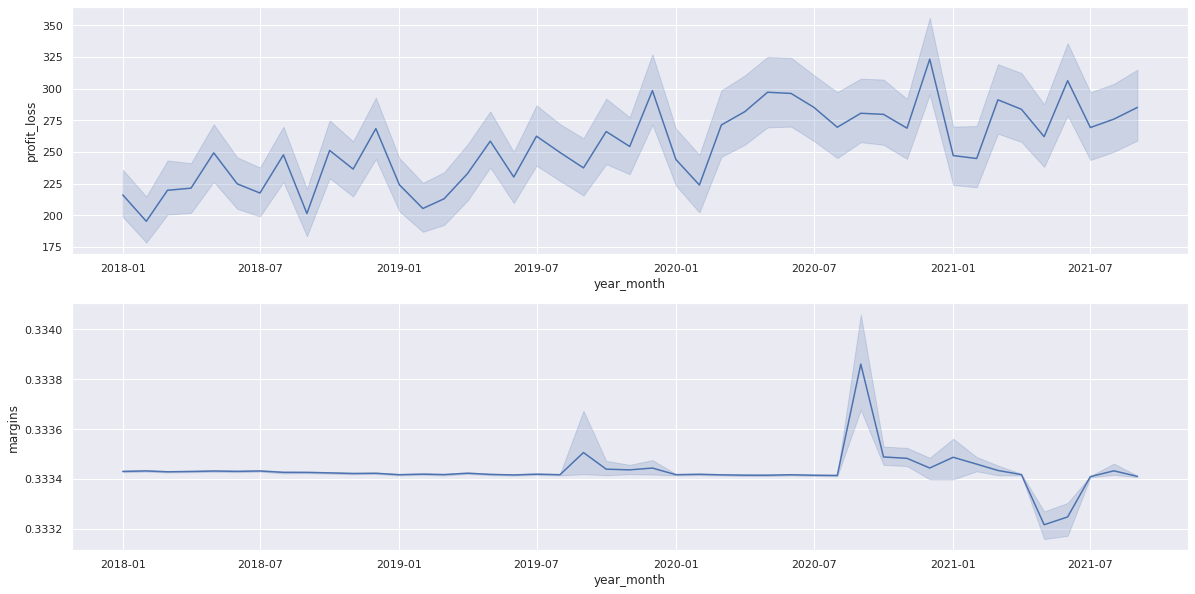

In [6]:
# plot time series
sns.set(rc={'figure.figsize':(20,10)})
fig, axs = plt.subplots(nrows=2)
sns.lineplot(x='year_month', y='profit_loss', data=profit_loss_timeseries, ax=axs[0])
sns.lineplot(x='year_month', y='margins', data=profit_loss_timeseries, ax=axs[1])

**Profitability of sales between 2018 and 2021 has been raising**  
General increase and upward trend of profit/loss, there is also a slight fall in margins of liquor sales below the average middle of 2021.

In [7]:
# Import process from fuzzywuzzy
from fuzzywuzzy import process

# Create a copy of time series with only category name column
unique_types  = profit_loss_timeseries['category_name'].unique()
category_col = profit_loss_timeseries['category_name'].copy()

liquor_category = ['Vodka', 'Whiskey', 'Scotch', 'Gin', 'Rum', 'Specialty', 'Cordials']

for category in liquor_category:
    # create a set of possible matches for each category
    possible_matches = process.extract(category, unique_types, limit = len(unique_types))
    for match in possible_matches:
        if category == 'Vodka' and match[1] >= 90:
            category_col.iloc[category_col == match[0]] = category
        elif category == 'Whiskey' and match[1] >= 70:
            category_col.iloc[category_col == match[0]] = category
        elif category == 'Scotch' and match[1] >= 90:
            category_col.iloc[category_col == match[0]] = category
        elif category == 'Gin' and match[1] >= 90:
            category_col.iloc[category_col == match[0]] = category
        elif category == 'Rum' and match[1] >= 90:
            category_col.iloc[category_col == match[0]] = category
        elif category == 'Specialty' and match[1] >= 90:
            category_col.iloc[category_col == match[0]] = category
        elif category == 'Cordials' and match[1] >= 90:
            category_col.iloc[category_col == match[0]] = category

# Set all other category to 'others'
category_col.loc[~category_col.isin(liquor_category)] = 'Others'

# Create new column with cleaned category
profit_loss_timeseries['liquor_category']  = category_col

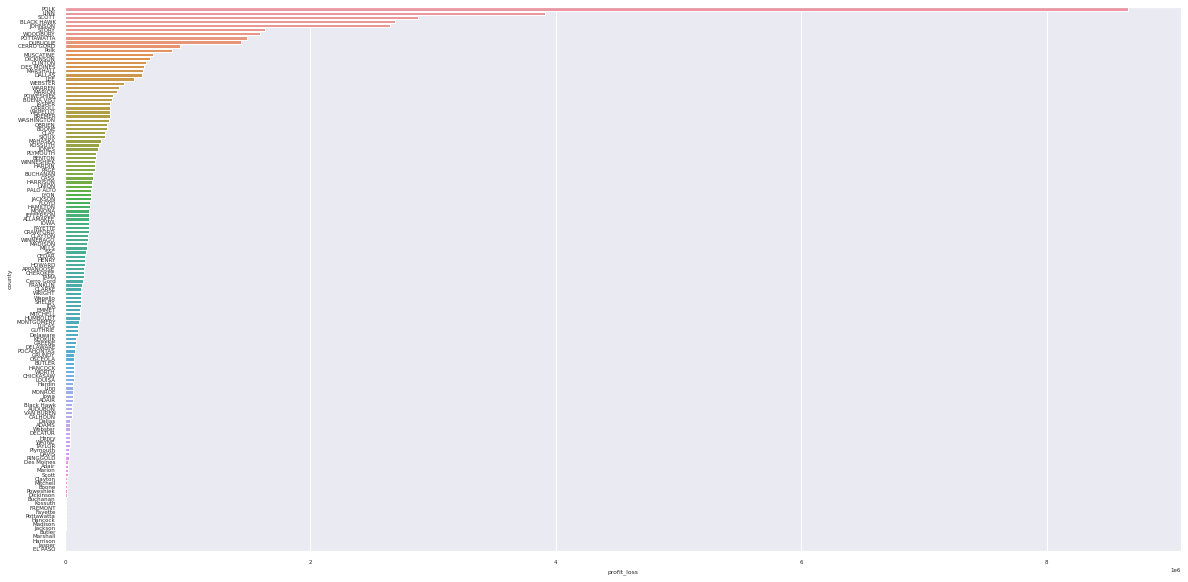

In [8]:
profit_loss_county = profit_loss_timeseries.groupby('county').sum().sort_values(by='profit_loss', ascending=False).reset_index()

sns.set(font_scale = 0.5)
g = sns.barplot(data=profit_loss_county, x='profit_loss', y='county')

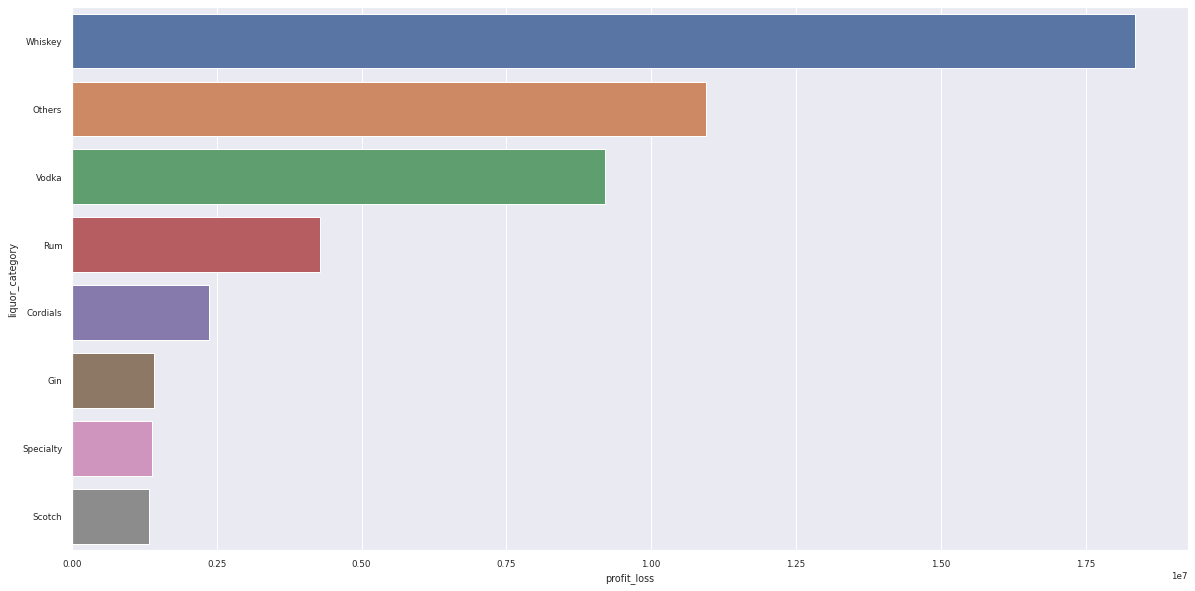

In [14]:
profit_loss_county = profit_loss_timeseries.groupby('liquor_category').sum().sort_values(by='profit_loss', ascending=False).reset_index()

sns.set(font_scale = 0.8)
g = sns.barplot(data=profit_loss_county, x='profit_loss', y='liquor_category')

 - Liquor across all categories maintain a 33% profit margin 
 - There are counties where sales are very low (below 10K)
 - Consider consolidating locations that are remote and low sales volume to cut transportation cost and ensure overall profitablility 